Dependencies

In [32]:
%pip install nltk rouge-score evaluate gensim word-mover-distance transformers POT

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/148.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/148.0 kB ? eta -:--:--
     ------------------------------- ------ 122.9/148.0 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 148.0/148.0 kB 1.8 MB/s eta 0:00:00
  Created wheel for word-mover-distance: filename=word_mover_distance-0.0.3-py3-none-any.whl size=4351 sha256=6b63bfd732316a0abcfb69dbf6a7621d72c31e027c9cc17234977b0d4878bf87
  Stored in directory: c:\users\aryam\appdata\local\pip\cache\wheels\5b\a3\b5\b43b98002cc219fbe9079ccd74607977b66146eb829998f6ca
Successfully built word-mover-distance
Note: you may need to restart the kernel to use updated packages.


Import all packages

In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from evaluate import load
import evaluate
import numpy 
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
from nltk.translate.meteor_score import meteor_score
import ot
import gensim.downloader as api
from nltk.corpus import stopwords
from time import time
import os
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from metrics import distances,eval
import tensorflow as tf
from sklearn.inspection import DecisionBoundaryDisplay
import bert_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

C:\Users\aryam\AppData\Roaming\Python\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

ALL Automatic Scorer functions

In [2]:
class Scorers:
    
    # BLEU
    def compute_bleu(self,reference, candidate):
        reference_tokens = nltk.word_tokenize(reference.lower())
        candidate_tokens = nltk.word_tokenize(candidate.lower())

        bleu_1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))
        bleu_2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0))
        bleu_3 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))

        return bleu_1, bleu_2, bleu_3, bleu_4
    
    # ROGUE
    def compute_rouge(self,reference, candidate):
        reference_tokens = reference.lower().split()
        candidate_tokens = candidate.lower().split()

        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        scores = scorer.score(reference, candidate)

        return scores

    # METEOR
    def compute_meteor(self,reference, candidate):

        reference =  nltk.word_tokenize(reference.lower())
        candidate =  nltk.word_tokenize(candidate.lower())

        score = meteor_score([reference], candidate)

        return score

    # WORD MOVERS DISTANCE    
    def compute_wmd(self,sentence_a,sentence_b,model):

        sentence_a = sentence_a.lower().split()
        sentence_b = sentence_b.lower().split()


        stop_words = stopwords.words('english')
        sentence_a = [w for w in sentence_a if w not in stop_words]
        sentence_b = [w for w in sentence_b if w not in stop_words]

        distance = model.wmdistance(sentence_a,sentence_b)

        return distance
    
    # TRANSLATION ERROR RATE
    def compute_ter(self,reference, candidate):

        ref_tokens = nltk.word_tokenize(reference.lower())
        cand_tokens = nltk.word_tokenize(candidate.lower())

        substitutions = nltk.edit_distance(ref_tokens, cand_tokens)
        deletions = len(ref_tokens) - len(set(ref_tokens) & set(cand_tokens))
        insertions = len(cand_tokens) - len(set(ref_tokens) & set(cand_tokens))

        reference_length = len(ref_tokens)
        ter = (substitutions + deletions + insertions) / reference_length

        return ter

    def compute_perplexity(self,text):
        model = AutoModelForCausalLM.from_pretrained("gpt2")
        tokenizer = AutoTokenizer.from_pretrained("gpt2")
        inputs = tokenizer(text, return_tensors = "pt")
        loss = torch.nn.CrossEntropyLoss() 
        final_loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
        ppl = torch.exp(final_loss)
        return ppl
    
    def Bert_Score(self, candidate, reference):
        return bert_score.score(candidate, reference,lang = "en")[2].item()
        

Save JSON

In [3]:
def save_json(data, filepath=r'new_data.json'):
    with open(filepath, 'w') as fp:
        json.dump(data, fp, indent=4)

Change path to Data 

In [4]:
data = json.load(open(r'data/pairwise_evaluation_w_embeddings.json'))

Compute all Scores for all pairs of data points(Need to run once)

In [5]:
scorer = Scorers()
model = api.load('word2vec-google-news-300')

full_embeddings = np.array([datum['full_embedding'] for datum in data])
writer_summary_embeddings = np.array([datum['writer_summary_embedding'] for datum in data])
llm_summary_embeddings = np.array([datum['llm_summary_embedding'] for datum in data])
writer_distances = distances.linear_regression_distance(full_embeddings, writer_summary_embeddings)
llm_distances = distances.linear_regression_distance(full_embeddings, llm_summary_embeddings)

for i,datum in enumerate(data):

    print('{}/{}'.format(i, len(data)))
    writer_summ = datum['writer_summary']
    llm_summ = datum['text-davinci-002_summary']
    article = datum['article_text']

    bleu_1,bleu_2,bleu_3,bleu_4 = scorer.compute_bleu(article,writer_summ)
    datum['bleu_1_writer'] = bleu_1
    datum['bleu_2_writer'] = bleu_2
    datum['bleu_3_writer'] = bleu_3
    datum['bleu_4_writer'] = bleu_4

    bleu_1,bleu_2,bleu_3,bleu_4 = scorer.compute_bleu(article,llm_summ)
    datum['bleu_1_llm'] = bleu_1
    datum['bleu_2_llm'] = bleu_2
    datum['bleu_3_llm'] = bleu_3
    datum['bleu_4_llm'] = bleu_4

    rogue = scorer.compute_rouge(article,writer_summ)
    datum['rogue_1_writer'] = rogue['rouge1'].fmeasure
    datum['rogue_2_writer'] = rogue['rouge2'].fmeasure
    datum['rogue_L_writer'] = rogue['rougeL'].fmeasure

    rogue = scorer.compute_rouge(article,llm_summ)
    datum['rogue_1_llm'] = rogue['rouge1'].fmeasure
    datum['rogue_2_llm'] = rogue['rouge2'].fmeasure
    datum['rogue_L_llm'] = rogue['rougeL'].fmeasure

    meteor = scorer.compute_meteor(article,writer_summ)
    datum['meteor_writer'] = meteor

    meteor = scorer.compute_meteor(article,llm_summ)
    datum['meteor_llm'] = meteor

    wmd = scorer.compute_wmd(article,writer_summ,model)
    datum['WMD_writer'] = wmd

    wmd = scorer.compute_wmd(article,llm_summ,model)
    datum['WMD_llm'] = wmd

    ter = scorer.compute_ter(article,writer_summ)
    datum['TER_writer'] = ter

    ter = scorer.compute_ter(article,llm_summ)
    datum['TER_llm'] = ter

    cosine_dist = distances.cosine_distance(datum['full_embedding'],datum['writer_summary_embedding'])
    datum['cosine_writer'] = cosine_dist

    cosine_dist = distances.cosine_distance(datum['full_embedding'],datum['llm_summary_embedding'])
    datum['cosine_llm'] = cosine_dist

    datum['lr_dist_writer'] = writer_distances[i]
    datum['lr_dist_llm'] = llm_distances[i]

    perplexity_writer = scorer.compute_perplexity(writer_summ)
    perplexity_llm = scorer.compute_perplexity(llm_summ)
    perp_writer = perplexity_writer.item()
    perp_llm = perplexity_llm.item()
    datum['Writer_Perplexity'] = perp_writer
    datum['LLM_Perplexity'] = perp_llm

    datum["Delta_Bert_Score"] = scorer.Bert_Score([writer_summ],[article]) - scorer.Bert_Score([llm_summ],[article])
save_json(data, r'data/All_Scores.json')


0/599


c:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


AssertionError: Different number of candidates and references

In [ ]:
save_json(data, r'data/All_Scores1.json')

In [16]:
final_data = json.load(open(r'data/All_Scores.json'))

Computing LR distance and deltas between scores(writer-llm)

In [20]:
full_embeddings = np.array([datum['full_embedding'] for datum in data])
writer_summary_embeddings = np.array([datum['writer_summary_embedding'] for datum in data])
llm_summary_embeddings = np.array([datum['llm_summary_embedding'] for datum in data])

distances_writer = distances.linear_regression_distance(full_embeddings,writer_summary_embeddings)
distances_llm = distances.linear_regression_distance(full_embeddings,llm_summary_embeddings)
for i,datum in enumerate(final_data):
    datum['Delta_LR'] = datum['lr_dist_writer'] - datum['lr_dist_llm']
    datum['Delra_Cosine'] = datum['cosine_writer'] - datum['cosine_llm']
    datum['delta_bleu_1'] = datum['bleu_1_writer'] - datum['bleu_1_llm']
    datum['delta_bleu_2'] = datum['bleu_2_writer'] - datum['bleu_2_llm']
    datum['delta_bleu_3'] = datum['bleu_3_writer'] - datum['bleu_3_llm']
    datum['delta_bleu_4'] = datum['bleu_4_writer'] - datum['bleu_4_llm']
    datum['delta_rogue_1'] = datum['rogue_1_writer'] - datum['rogue_1_llm']
    datum['delta_rogue_2'] = datum['rogue_2_writer'] - datum['rogue_2_llm']
    datum['delta_rogue_L'] = datum['rogue_L_writer'] - datum['rogue_L_llm']
    datum['delta_meteor'] = datum['meteor_writer'] - datum['meteor_llm']
    datum['delta_WMD'] = datum['WMD_writer'] - datum['WMD_llm']
    datum['delta_TER'] = datum['TER_writer'] - datum['TER_llm']

Saving results for neural network configurations.

In [ ]:
result_list_pca = []
def save_results_NN(model, cf, acc, sampling, epochs, bz,var,loss,drop):
    result = {}
    result['Model Architecture'] = model
    result['Sampling Technique'] = sampling
    result['Testing Accuracy'] = acc
    result['Confusion Matrix'] = cf
    result['epochs'] = epochs
    result['batch  size'] = bz
    result['Variance Ratios'] = var
    result['Loss'] = loss
    result['Dropped columns (PCA)'] = drop
    result_list_pca.append(result)
    return result_list_pca
save_json(result_list_pca, r'data/All_Scores1.json')

Saving final data for model training. 

In [21]:
save_json(final_data, r'data/data_model1.json')

In [4]:
final_data = json.load(open(r'data/data_model1.json'))

In [5]:
df = pd.DataFrame(final_data)

In [14]:
df

,article_id,writer_id,evaluator_id,article_text,writer_summary,text-davinci-002_summary,overall_writer_better,informative_writer_better,full_embedding,writer_summary_embedding,...,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_rogue_L,delta_meteor,delta_WMD,delta_TER
0,18cba9a8f2f64055a707452638182303,133d66ad12ab449e8c607d188b65e948,9d49ddd0-7c67-4394-8d6b-e685a982e956,Baltimore's mayor has sacked the US city's pol...,The mayor of Baltimore fired the police chief ...,The mayor of Baltimore has sacked the city's p...,False,Equally Good,"[-0.007163366, 0.0075295228, -0.022528652, -0....","[-0.0027573644, -0.0059608207, -0.017378185, -...",...,9.315888e-05,-2.227870e-04,-3.952263e-04,-5.884357e-04,-0.016795,-0.119741,-0.075281,-0.010755,0.102884,0.120482
1,66f39853ad2b437c8bdca86ae74bb35f,85b4d7406d144eacaede6397fafe06b9,0ec347ce-79c1-4495-8f84-43f2f57deb82,Western Sahara has welcomed Morocco's readmiss...,Morocco joined the African Union after a refer...,The article discusses Western Sahara's reactio...,False,False,"[0.0064340984, -0.013940546, 0.022131747, -0.0...","[-0.0016521142, -0.024277786, 0.004347165, -0....",...,-1.181609e-03,-9.724130e-04,-8.214662e-04,-7.150524e-04,-0.135906,-0.119886,-0.085016,-0.054849,0.122838,0.038934
2,302c800172da420f9e2e80474a9cf5ec,85b4d7406d144eacaede6397fafe06b9,0ec347ce-79c1-4495-8f84-43f2f57deb82,With the new Avengers: Age of Ultron movie rel...,James Haskell is a rugby player for the London...,"James Haskell, a rugby player for London Wasps...",Equally Good,Equally Good,"[-0.0070248763, -0.00925884, 0.0027083454, -0....","[-0.024424886, -0.0077787954, -0.0036272286, -...",...,1.304745e-03,1.048415e-03,8.768482e-04,6.623418e-04,-0.013165,-0.006566,-0.060957,-0.005585,0.098476,0.034384
3,14f71296e6404651bfdcfd300ddebcf8,7c02dffbfb0348f68758c00334878ef7,d3727ca5-7197-4a03-81a0-2137ebcd52f4,UK manufacturing activity contracted in April ...,Concerns over UK manufacturing activity have b...,The Markit/CIPS manufacturing Purchasing Manag...,False,False,"[-0.023462681, -0.024742227, -0.018057255, -0....","[-0.011470091, -0.036104277, -0.009304092, -0....",...,-2.063083e-03,-1.932978e-03,-1.775976e-03,-1.626403e-03,-0.087471,-0.138185,-0.070246,-0.034352,0.057226,0.056566
4,5a5d2bbfb7a74067abfb31a5f4888c71,564736de98b54961a003a097c04d7b50,d3727ca5-7197-4a03-81a0-2137ebcd52f4,An obese mother who enjoyed takeaways and booz...,"Lizzi, an obese mother of six, wouldn't have r...","Lizzi Crawford, 32, from Stoke-on-Trent, lost ...",False,False,"[0.0010762861, 0.00084113114, 0.0077814907, -0...","[0.00010524096, 0.007291257, 0.010436634, -0.0...",...,1.080080e-05,6.755834e-06,3.990179e-06,2.126423e-06,-0.022163,-0.070873,-0.040980,-0.000067,0.006605,0.042050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,3b82559a2edb48c7bffca655c43fe34d,b33c38a1cc7a45358cbcd30311e78ae2,d3727ca5-7197-4a03-81a0-2137ebcd52f4,It's every interviewer's worst nightmare. Ask ...,When a News 4 presenter attempted to ask Rober...,The article discusses celebrities who have wal...,False,False,"[-0.0048403596, -0.01597452, 0.029282175, -0.0...","[-0.012659721, -0.015550625, 0.025793782, -0.0...",...,4.242518e-12,2.664889e-12,1.383620e-12,6.944559e-13,0.028901,0.011844,0.021000,0.008115,-0.050421,-0.002553
595,24df2a97c6a94a40b5f291ad5e5314b0,f7427d27b63541b8b3b1099c5f32f7de,9d49ddd0-7c67-4394-8d6b-e685a982e956,The Liberal Democrats have admitted they are o...,The Liberal Democrats are optimistic about win...,The Liberal Democrats are on course to lose at...,Equally Good,Equally Good,"[-0.00969115, 0.0142671615, 0.017133743, -0.01...","[-0.02096688, -0.00027541863, 0.0039957105, -0...",...,-3.804338e-12,-7.245773e-12,-7.345113e-12,-6.524121e-12,-0.011018,-0.023912,-0.014251,-0.002725,0.081895,0.021180
596,2c80f9196b654048b01397ebd52d3518,564736de98b54961a003a097c04d7b50,d3727ca5-7197-4a03-81a0-2137ebcd52f4,A Hertfordshire council is buying in water fr

Dropping the columns not used for training

In [6]:
final_data = df.drop(columns=['cosine_writer','cosine_llm','lr_dist_writer','lr_dist_llm','Writer_Perplexity','LLM_Perplexity','writer_id', 'evaluator_id','article_text','writer_summary','text-davinci-002_summary','article_id','bleu_1_writer','bleu_2_writer','bleu_3_writer','bleu_4_writer','bleu_1_llm','bleu_2_llm','bleu_3_llm','bleu_4_llm','rogue_1_writer','rogue_2_writer','rogue_L_writer','rogue_1_llm','rogue_2_llm','rogue_L_llm','meteor_writer','meteor_llm','TER_writer','TER_llm','WMD_writer','WMD_llm'])

Changing values to string for Label Encoder. Use this to predict overall_writer_better.

In [7]:
final_data['overall_writer_better'] = [str(value) for value in final_data['overall_writer_better']]

Changing values to string for Label Encoder. Use this to predict informative_writer_better.

In [8]:
final_data['informative_writer_better'] = [str(value) for value in final_data['informative_writer_better']]

Using Label Encoder to convert 'True, False and Equally good' to '0, 1, 2'

In [9]:
encoder = LabelEncoder()
final_data['overall_writer_better'] = encoder.fit_transform(final_data['overall_writer_better'])
final_data['informative_writer_better'] = encoder.fit_transform(final_data['informative_writer_better'])

Change labels to informative_writer_better to predict its values

In [10]:
X = final_data.drop(columns=['overall_writer_better','full_embedding','writer_summary_embedding','llm_summary_embedding','informative_writer_better'])
labels = final_data['overall_writer_better']

Undersampling the classes except the minority class

In [44]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, labels)

Using Random Sampler for oversampling the classes that are not the majority

In [153]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not majority',random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, labels)

Using SMOTE for oversampling the classes that are not the majority

In [235]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, labels)

In [12]:
final_data

,overall_writer_better,informative_writer_better,full_embedding,writer_summary_embedding,llm_summary_embedding,Delta_Bert_Score,Delta_LR,Delra_Cosine,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_rogue_L,delta_meteor,delta_WMD,delta_TER
0,1,0,"[-0.007163366, 0.0075295228, -0.022528652, -0....","[-0.0027573644, -0.0059608207, -0.017378185, -...","[-0.017751856, 0.0023727566, -0.016772991, -0....",-0.027883,25.234356,-0.064297,9.315888e-05,-2.227870e-04,-3.952263e-04,-5.884357e-04,-0.016795,-0.119741,-0.075281,-0.010755,0.102884,0.120482
1,1,1,"[0.0064340984, -0.013940546, 0.022131747, -0.0...","[-0.0016521142, -0.024277786, 0.004347165, -0....","[0.003536, -0.0033973965, 0.026843945, -0.0226...",-0.038863,28.330607,-0.034410,-1.181609e-03,-9.724130e-04,-8.214662e-04,-7.150524e-04,-0.135906,-0.119886,-0.085016,-0.054849,0.122838,0.038934
2,0,0,"[-0.0070248763, -0.00925884, 0.0027083454, -0....","[-0.024424886, -0.0077787954, -0.0036272286, -...","[-0.021199895, -0.013502783, 0.0009260177, -0....",-0.001070,26.154262,0.000946,1.304745e-03,1.048415e-03,8.768482e-04,6.623418e-04,-0.013165,-0.006566,-0.060957,-0.005585,0.098476,0.034384
3,1,1,"[-0.023462681, -0.024742227, -0.018057255, -0....","[-0.011470091, -0.036104277, -0.009304092, -0....","[-0.027852064, -0.026193894, -0.018356454, -0....",-0.032617,27.664598,-0.037909,-2.063083e-03,-1.932978e-03,-1.775976e-03,-1.626403e-03,-0.087471,-0.138185,-0.070246,-0.034352,0.057226,0.056566
4,1,1,"[0.0010762861, 0.00084113114, 0.0077814907, -0...","[0.00010524096, 0.007291257, 0.010436634, -0.0...","[-0.004452347, 0.0064872345, 0.011028628, -0.0...",-0.035254,25.123670,-0.020341,1.080080e-05,6.755834e-06,3.990179e-06,2.126423e-06,-0.022163,-0.070873,-0.040980,-0.000067,0.006605,0.042050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,1,1,"[-0.0048403596, -0.01597452, 0.029282175, -0.0...","[-0.012659721, -0.015550625, 0.025793782, -0.0...","[-0.0039800056, -0.0050657564, 0.031451117, -0...",0.014129,23.280861,0.013741,4.242518e-12,2.664889e-12,1.383620e-12,6.944559e-13,0.028901,0.011844,0.021000,0.008115,-0.050421,-0.002553
595,0,0,"[-0.00969115, 0.0142671615, 0.017133743, -0.01...","[-0.02096688, -0.00027541863, 0.0039957105, -0...","[-0.026044741, -0.009718284, 0.012808995, -0.0...",-0.040747,25.522454,-0.032433,-3.804338e-12,-7.245773e-12,-7.345113e-12,-6.524121e-12,-0.011018,-0.023912,-0.014251,-0.002725,0.081895,0.021180
596,2,2,"[0.016982611, -0.0031427317, -0.015396845, -0....","[0.023978898, -0.008586212, -0.002757913, 0.00...","[0.01525739, -0.012522703, -0.022811625, -0.00...",-0.008726,28.171980,-0.015478,2.485266e-03,1.172490e-03,3.204935e-04,-1.092109e-04,0.022454,-0.043864,-0.015294,0.017959,-0.117015,0.033033
597,2,2,"[-0.009644198, -0.0059027453, 0.0016152562, -0...","[-0.005729174, -0.019543953, 0.0024205518, -0....","[0.005884727, -0.0063239825, 0.023203008, -0.0...",-0.001677,26.752569,0.003635,1.616343e-04,1.064409e-04,7.318380e-05,5.053922e-05,0.071033,0.002296,0.024982,0.022808,-0.058163,-0.011338


Check the values of each class in dataset

In [11]:
labels.value_counts()

overall_writer_better
2    243
1    239
0    117
Name: count, dtype: int64

Normalization with no sampling

In [16]:
X_scaled = X.copy()  
for column in X_scaled.columns: 
    X_scaled[column] = (X_scaled[column] - X_scaled[column].mean()) / X_scaled[column].std()   

Normalization with sampling

In [237]:
X_scaled = X_resampled.copy()  
for column in X_scaled.columns: 
    X_scaled[column] = (X_scaled[column] - X_scaled[column].mean()) / X_scaled[column].std()   

Correlation between features in dataset

<function matplotlib.pyplot.show(close=None, block=None)>

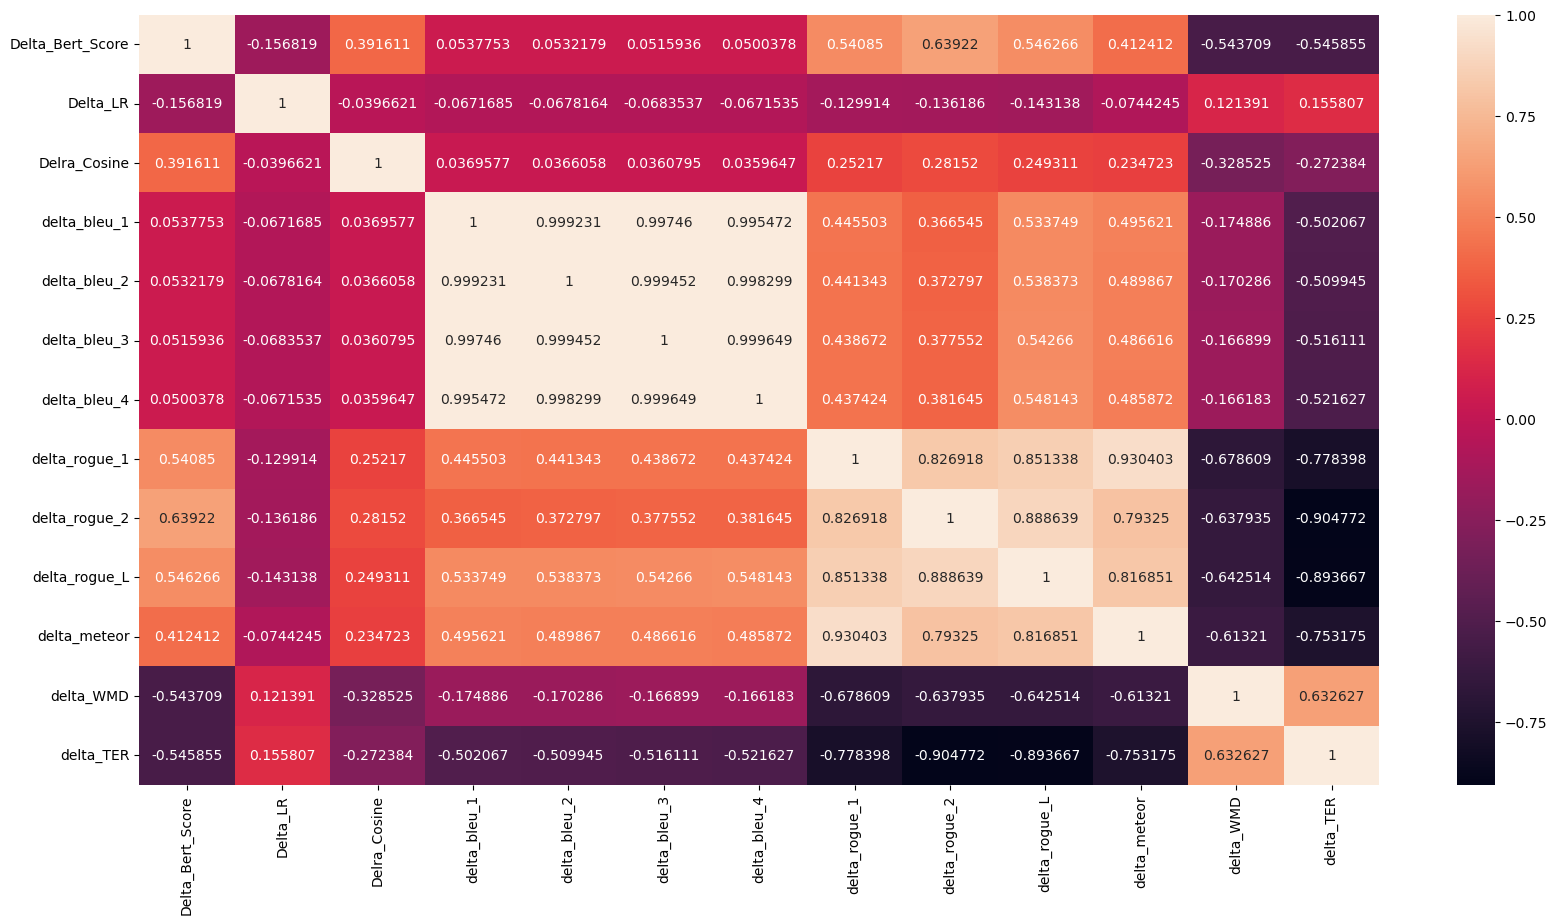

In [250]:
import seaborn as sns

correlation_matrix = X_scaled.corr()

cov_matrix = np.cov(X_scaled, rowvar=False)
plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True, fmt='g')

plt.show

Train Test and Validation Split

In [17]:
x, x_test, y, y_test = train_test_split(X_scaled,labels,test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)

Final training data

In [18]:
x_train.columns

Index(['Delta_Bert_Score', 'Delta_LR', 'Delra_Cosine', 'delta_bleu_1',
       'delta_bleu_2', 'delta_bleu_3', 'delta_bleu_4', 'delta_rogue_1',
       'delta_rogue_2', 'delta_rogue_L', 'delta_meteor', 'delta_WMD',
       'delta_TER'],
      dtype='object')

Final Labels

In [115]:
labels

0      1
1      1
2      0
3      1
4      1
      ..
594    1
595    0
596    2
597    2
598    2
Name: overall_writer_better, Length: 599, dtype: int32

In [14]:
result_list = []
def save_results(model_name, cf, acc, sampling,tuning):
    result = {}
    result['Model Name'] = model_name
    result['Sampling Technique'] = sampling
    result['Testing Accuracy'] = acc
    result['Confusion Matrix'] = cf
    result['Hyperparameter Tuning'] = tuning
    result_list.append(result)
    return result_list

KNN Classifier

In [116]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6,metric = 'minkowski', p = 2)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print (cm_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)
print (acc_knn)

save_results("KNN",cm_knn,acc_knn,"SMOTE Sampling","No")

[[36  6  7]
 [20 19 12]
 [16 12 18]]
0.5


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

SVM

In [117]:
from sklearn.svm import SVC

svc_rbf = SVC(kernel = 'linear', random_state = 0)
svc_rbf.fit(x_train, y_train)
y_pred_svc_rbf = svc_rbf.predict(x_test)

cm_svc = confusion_matrix(y_test, y_pred_svc_rbf)
print (cm_svc)
acc_svc_rbf = accuracy_score(y_test, y_pred_svc_rbf)
print (acc_svc_rbf)

save_results("SVM",cm_svc,acc_svc_rbf,"SMOTE Sampling","No")

[[29  3 17]
 [16 20 15]
 [15  4 27]]
0.5205479452054794


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Naive-Bayes

In [118]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

cm_nb = confusion_matrix(y_test, y_pred)
print(cm_nb)
acc_nb = accuracy_score(y_test, y_pred)
print(acc_nb)

save_results("Naive Bayes",cm_nb,acc_nb,"SMOTE Sampling","No")

[[ 3  2 44]
 [ 1 12 38]
 [ 0  1 45]]
0.410958904109589


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Decision Tree Classifier

In [119]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

cm_dt = confusion_matrix(y_test, y_pred)
print (cm_dt)
acc_dt = accuracy_score(y_test, y_pred)
print (acc_dt)

save_results("Decision Tree",cm_dt,acc_dt,"SMOTE Sampling","No")

[[30  7 12]
 [14 21 16]
 [ 9 18 19]]
0.4794520547945205


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Random Forest Classifier with grid search for hyperparameter tuning

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': range(50, 100, 50),  # [50, 100, 150]
    'max_depth': np.arange(0, 10, 1),  # [10, 20, ..., 90]
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),  # [0.1, 0.2, ..., 1.0]
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train,y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)


best_score = grid_search.best_score_
print("Best score:", best_score)

y_pred = grid_search.predict(x_test)

cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

save_results("Random Forest",cm_rf,best_score,"SMOTE Sampling","Yes")

Best parameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_split': 0.4, 'n_estimators': 50}
Best score: 0.5217603527003621
[[38  5  6]
 [21 20 10]
 [16  5 25]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\Lib\site-packag

[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Random forest without Hyperparameter tuning

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42,class_weight=None)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
accuracy = rf.score(x_test, y_test)

cm_rf = confusion_matrix(y_test, y_pred)
print (cm_rf)

print('Accuracy:', accuracy)

save_results("Random Forest",cm_rf,accuracy,"SMOTE Sampling","No")

[[41  5  3]
 [22 20  9]
 [17  5 24]]
Accuracy: 0.5821917808219178


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

AdaBoost Classifier

In [122]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(x_train, y_train)

y_pred_abc = abc.predict(x_test)
cm_ada = confusion_matrix(y_test, y_pred_abc)
print (cm_ada)
acc_abc = accuracy_score(y_test, y_pred_abc)
print (acc_abc)

save_results("Ada Boost",cm_ada,acc_abc,"SMOTE Sampling","No")

[[31  9  9]
 [ 9 26 16]
 [13  9 24]]
0.5547945205479452


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Quadratic discriminant analysis

In [123]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

y_pred_qda = qda.predict(x_test)
cm_qda = confusion_matrix(y_test, y_pred_qda)
print (cm_qda)
acc_qda = accuracy_score(y_test, y_pred_qda)
print (acc_qda)

save_results("Quadratic Discriminant Analysis",cm_qda,acc_qda,"SMOTE Sampling","No")

[[ 8  1 40]
 [ 2 11 38]
 [ 1  2 43]]
0.4246575342465753


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

MLP Classifier with Hyperparameter tuning

In [124]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(x_train, y_train)

param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(10, 120, 10)],  # [(50,), (100,), (150,)]
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': np.linspace(0.0001, 1, 5),  # [0.0001, 0.012575, 0.02505, 0.037525, 0.05]
    'learning_rate': ['constant','adaptive'],
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train,y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_score = grid_search.best_score_
print("Best score:", best_score)

y_pred = grid_search.predict(x_test)

cm_mlp1 = confusion_matrix(y_test, y_pred)
print(cm_mlp1)

save_results("MLP",cm_mlp1,best_score,"SMOTE Sampling","Yes")

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'activation': 'relu', 'alpha': 0.7500249999999999, 'hidden_layer_sizes': (90,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best score: 0.49888206581640687
[[28  6 15]
 [18 20 13]
 [14  5 27]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

MLP Classifier without Hyperparameter tuning

In [125]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=0.01, max_iter=1000)
mlp.fit(x_train, y_train)

y_pred_mlp = mlp.predict(x_test)
cm = confusion_matrix(y_test, y_pred_mlp)
print (cm)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print (acc_mlp)

save_results("MLP",cm,acc_mlp,"SMOTE Sampling","No")

[[33  5 11]
 [11 24 16]
 [10  7 29]]
0.589041095890411


[{'Model Name': 'KNN',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.4,
  'Confusion Matrix': array([[ 4, 11, 15],
         [ 7, 18, 19],
         [ 8, 12, 26]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'SVM',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[ 0, 12, 18],
         [ 0, 22, 22],
         [ 0, 14, 32]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Naive Bayes',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.48333333333333334,
  'Confusion Matrix': array([[ 2,  0, 28],
         [ 0, 12, 32],
         [ 1,  1, 44]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Decision Tree',
  'Sampling Technique': 'No Sampling',
  'Testing Accuracy': 0.45,
  'Confusion Matrix': array([[10,  8, 12],
         [ 6, 24, 14],
         [10, 16, 20]], dtype=int64),
  'Hyperparameter Tuning': 'No'},
 {'Model Name': 'Random Forest',
  'Sampling Technique':

Sort and store results

In [126]:
temp = result_list
for item in temp:
    for key, value in item.items():
        if isinstance(value, np.ndarray):
            item[key] = value.tolist()
temp = sorted(temp, key=lambda x: x['Model Name'])
with open('data/results1.json', 'w') as json_file:
    json.dump(temp, json_file, indent=2)

View Results Dataframe

In [3]:
with open('data/results1.json', encoding='utf-8') as inputfile:
    df = pd.read_json(inputfile)

df.to_csv('data/csv_res_models.csv', encoding='utf-8', index=False)

In [127]:
res = json.load(open(r'data/results1.json'))
res_df = pd.DataFrame(res)
res_df

,Model Name,Sampling Technique,Testing Accuracy,Confusion Matrix,Hyperparameter Tuning
0,Ada Boost,No Sampling,0.433333,"[[8, 11, 11], [4, 24, 16], [5, 21, 20]]",No
1,Ada Boost,Under Sampling,0.309859,"[[9, 10, 10], [5, 7, 9], [6, 9, 6]]",No
2,Ada Boost,Random Over Sampling,0.513699,"[[28, 10, 12], [14, 22, 10], [8, 17, 25]]",No
3,Ada Boost,SMOTE Sampling,0.554795,"[[31, 9, 9], [9, 26, 16], [13, 9, 24]]",No
4,Decision Tree,No Sampling,0.450000,"[[10, 8, 12], [6, 24, 14], [10, 16, 20]]",No
5,Decision Tree,Under Sampling,0.253521,"[[11, 10, 8], [9, 5, 7], [10, 9, 2]]",No
6,Decision Tree,Random Over Sampling,0.479452,"[[34, 8, 8], [14, 22, 10], [13, 23, 14]]",No
7,Decision Tree,SMOTE Sampling,0.479452,"[[30, 7, 12], [14, 21, 16], [9, 18, 19]]",No
8,KNN,No Sampling,0.400000,"[[4, 11, 15], [7, 18, 19], [8, 12, 26]]",No
9,KNN,Under Sampling,0.267606,"[[7, 10, 12], [6, 5, 10], [7, 7, 7]]",No


Observations:

In almost all cases under sampling underperforms

Hyperparameter tuning increases testing accuracy consistantly

No sampling/ SMOTE sampling gives better accuracies in most cases

Linear regression with softmax

In [214]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_scaled)

In [215]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_onehot = lb.fit_transform(y_resampled)

X_train, X_test, Y_train, Y_test = train_test_split(X_pca_train, y_onehot, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)

predictions = model.predict(X_test)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

probabilities = softmax(predictions)
y_pred = np.argmax(probabilities, axis=1)
accuracy = accuracy_score(np.argmax(Y_test, axis=1), y_pred)
print(f'Accuracy: {accuracy:.2f}')

cm = confusion_matrix(np.argmax(Y_test, axis=1), y_pred)
print('Confusion Matrix:')
print(cm)

Accuracy: 0.51
Confusion Matrix:
[[14  8 15]
 [13 28 11]
 [12 13 32]]


C:\Users\aryam\AppData\Local\Temp\ipykernel_36844\2331925975.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


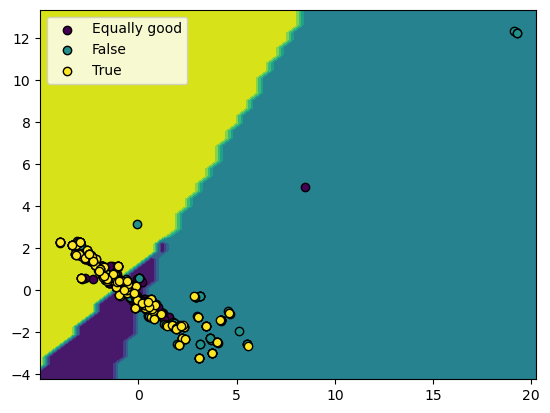

In [216]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_train[:, 0].min()-1, X_train[:, 0].max()+1),np.linspace(X_train[:, 1].min()-1, X_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))
Y_train_1D = np.argmax(Y_train, axis=1)
for i, class_label in enumerate(class_labels):
    mask = Y_train_1D == i
    display.ax_.scatter(X_train[mask, 0], X_train[mask, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

Observations:

Using the current feature set, the labels are indistinguishable, could be because of the delta values being very similar and small making it tough for the models to distinguist the labels



Logistic Regression

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(x_train)
X_pca_test = pca.fit_transform(x_test)

In [335]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

model_lr.fit(X_pca_train, y_train)

predictions = model_lr.predict(X_pca_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test, predictions)
print (cm)

Accuracy: 0.4589041095890411
[[ 5 15 30]
 [ 5 25 16]
 [ 5  8 37]]


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\4054909990.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


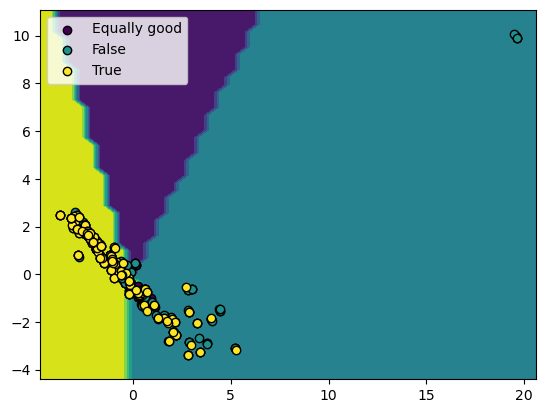

In [333]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model_lr.predict(grid)
# predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(probabilities, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

MLP with Softmax

Epoch 1/150
146/146 [==============================] - 1s 1ms/step - loss: 1.0949 - accuracy: 0.4005
Epoch 2/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0833 - accuracy: 0.3982
Epoch 3/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0770 - accuracy: 0.4096
Epoch 4/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0768 - accuracy: 0.4142
Epoch 5/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0775 - accuracy: 0.3959
Epoch 6/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0879 - accuracy: 0.4188
Epoch 7/150
146/146 [==============================] - 0s 2ms/step - loss: 1.0821 - accuracy: 0.4096
Epoch 8/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0845 - accuracy: 0.4096
Epoch 9/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0812 - accuracy: 0.3890
Epoch 10/150
146/146 [==============================] - 0s 1ms/step - loss: 1.0818 - accura

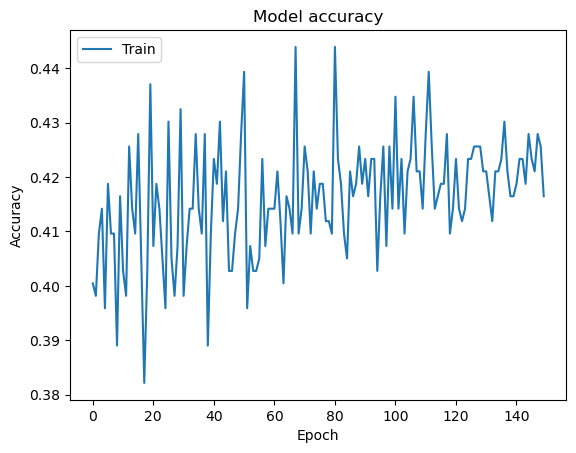

In [337]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_dim=X_pca_train.shape[1], activation='linear'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.5)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_pca_train, y_train, epochs=150, batch_size=3)

y_preds = np.argmax(model.predict(X_pca_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_preds)
print(conf_matrix)
# weights = model.layers[0].get_weights()[0]
# print(weights)

# for layer in model.layers:
#     weights = layer.get_weights()
#     print(f'Weights for layer {layer.name}: {weights}')

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()



Neural network 

79/79 [==============================] - 0s 1ms/step


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\885984525.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


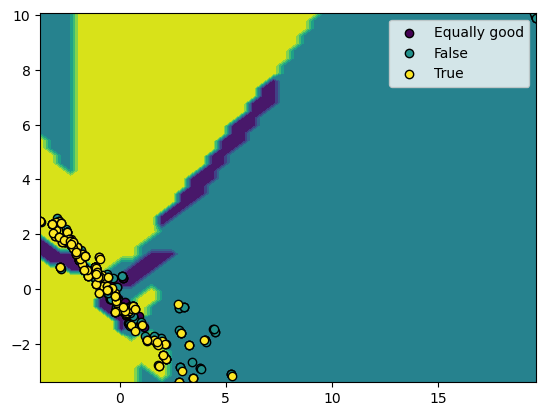

In [269]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

With Relu Activation

79/79 [==============================] - 0s 1ms/step


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\885984525.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


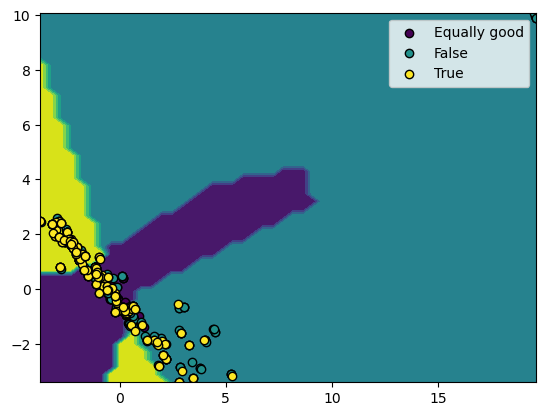

In [267]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

With Linear Activation

79/79 [==============================] - 0s 1ms/step


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\885984525.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


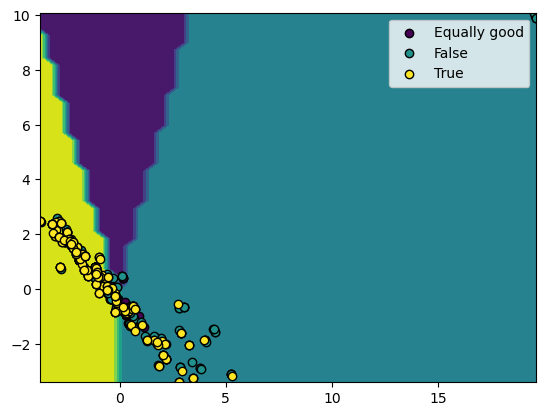

In [265]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

With Tanh activation

79/79 [==============================] - 0s 1ms/step


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\885984525.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


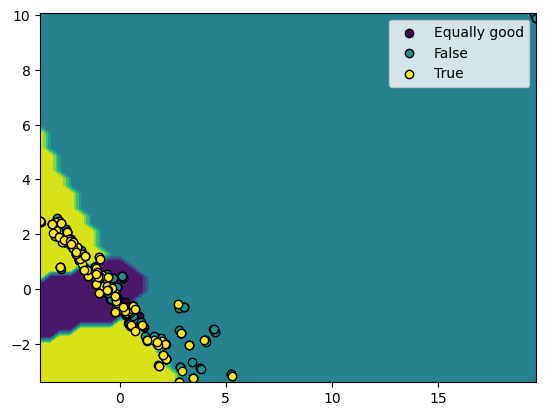

In [263]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

With Sigmoid Activation

79/79 [==============================] - 0s 1ms/step


C:\Users\aryam\AppData\Local\Temp\ipykernel_36508\885984525.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(class_labels))


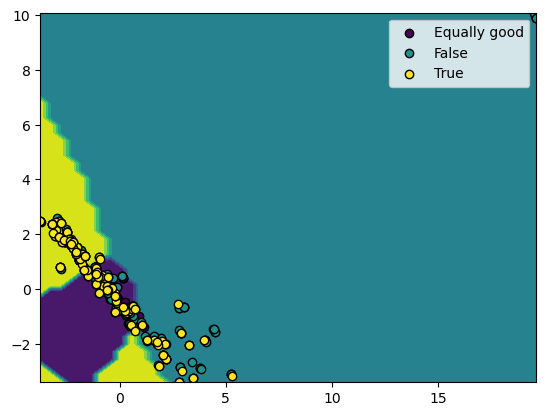

In [261]:
feature_1, feature_2 = np.meshgrid(np.linspace(X_pca_train[:, 0].min()-1, X_pca_train[:, 0].max()+1),np.linspace(X_pca_train[:, 1].min()-1, X_pca_train[:, 1].max()+1))
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

probabilities = model.predict(grid)
predictions = np.argmax(probabilities, axis=1)
y_pred = np.reshape(predictions, feature_1.shape)
class_labels = ['Equally good','False','True']
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()

cmap = plt.cm.get_cmap('viridis', len(class_labels))

for i, class_label in enumerate(class_labels):
    display.ax_.scatter(X_pca_train[y_train == i, 0], X_pca_train[y_train == i, 1], edgecolor="black",label = class_label,color=cmap(i))

plt.legend()
plt.show()

In [242]:
result_list_NN = []
def save_results_NN(model, cf, acc, sampling, epochs, bz,var,loss,drop):
    result = {}
    result['Model Architecture'] = model
    result['Sampling Technique'] = sampling
    result['Testing Accuracy'] = acc
    result['Confusion Matrix'] = cf
    result['epochs'] = epochs
    result['batch  size'] = bz
    result['Variance Ratios'] = var
    result['Loss'] = loss
    result['Dropped columns (PCA)'] = drop
    result_list_NN.append(result)
    return result_list_NN

MLP with PCA

Epoch 1/100
146/146 [==============================] - 1s 2ms/step - loss: 1.0950 - accuracy: 0.4211
Epoch 2/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0771 - accuracy: 0.4600
Epoch 3/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0524 - accuracy: 0.4188
Epoch 4/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0521 - accuracy: 0.4691
Epoch 5/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0542 - accuracy: 0.4783
Epoch 6/100
146/146 [==============================] - 0s 2ms/step - loss: 1.0473 - accuracy: 0.4783
Epoch 7/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0593 - accuracy: 0.5126
Epoch 8/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0449 - accuracy: 0.4874
Epoch 9/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0515 - accuracy: 0.5149
Epoch 10/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0444 - accura

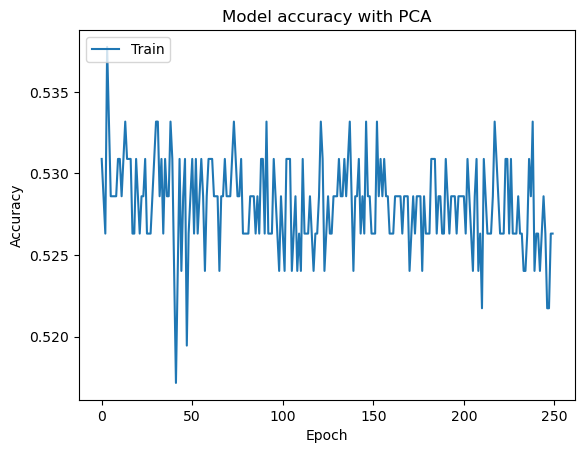

In [243]:
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)

X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_dim=x_train.shape[1], activation='linear'),
    # tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])
epochs_list = [100,200,250]
batch_size_list = [3,25,50]
for bz in batch_size_list:
    for ep in epochs_list:
        model_pca.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history_pca = model_pca.fit(x_train, y_train, epochs=ep, batch_size=bz)
        y_preds = np.argmax(model_pca.predict(x_test), axis=1)
        conf_matrix = confusion_matrix(y_test, y_preds)
        var = pca.explained_variance_ratio_
        test_loss, test_accuracy = model_pca.evaluate(x_test, y_test, verbose=2)
        save_results_NN("Linear-softmax",conf_matrix,test_accuracy,"SMOTE Over Sampling",ep,bz,var,test_loss,"None")
# print("Shape of components_: ", pca.components_.shape)


# for i, component in enumerate(pca.components_):
#     print(f"Component {i+1}:")
#     for feature, weight in zip(list(x_train.columns), component):
#         print(f"{feature}: {weight}")

# average_weights = np.mean(pca.components_, axis=0)

# print(pca.components_)

# for feature, avg_weight in zip(list(x_train.columns), average_weights):
#     print(f"{feature}: {avg_weight}")

plt.plot(history_pca.history['accuracy'])
plt.title('Model accuracy with PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# print('Explained variance ratio: ', pca.explained_variance_ratio_)

# test_loss, test_accuracy = model_pca.evaluate(x_test, y_test, verbose=2)
# print(f'\nTest accuracy: {test_accuracy}')

In [244]:
temp = result_list_NN
for item in temp:
    for key, value in item.items():
        if isinstance(value, np.ndarray):
            item[key] = value.tolist()
temp = sorted(temp, key=lambda x: x['Model Architecture'])
with open('data/results_NN1.json', 'w') as json_file:
    json.dump(temp, json_file, indent=2)

In [246]:
res = json.load(open(r'data/results_NN.json'))
res_df = pd.DataFrame(res)
res_df

,Model Architecture,Sampling Technique,Testing Accuracy,Confusion Matrix,epochs,batch size,Variance Ratios,Loss,Dropped columns (PCA)
0,Linear-softmax,None,0.450000,"[[0, 9, 14], [1, 26, 23], [0, 19, 28]]",100,3,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.018129,None
1,Linear-softmax,None,0.500000,"[[0, 9, 14], [1, 28, 21], [0, 15, 32]]",200,3,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.013788,None
2,Linear-softmax,None,0.466667,"[[0, 10, 13], [1, 29, 20], [0, 20, 27]]",250,3,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.018382,None
3,Linear-softmax,None,0.500000,"[[0, 9, 14], [1, 28, 21], [0, 15, 32]]",100,25,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.021076,None
4,Linear-softmax,None,0.466667,"[[0, 9, 14], [1, 28, 21], [0, 19, 28]]",200,25,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.023019,None
5,Linear-softmax,None,0.500000,"[[0, 9, 14], [1, 28, 21], [1, 14, 32]]",250,25,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.022666,None
6,Linear-softmax,None,0.500000,"[[0, 9, 14], [1, 28, 21], [0, 15, 32]]",100,50,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.023726,None
7,Linear-softmax,None,0.458333,"[[0, 8, 15], [1, 26, 23], [0, 18, 29]]",200,50,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.024900,None
8,Linear-softmax,None,0.508333,"[[0, 9, 14], [1, 29, 20], [0, 15, 32]]",250,50,"[0.5514927437618179, 0.2135647946202512, 0.086...",1.024918,None
9,Linear-softmax,Under Sampling,0.281690,"[[7, 8, 7], [9, 9, 8], [6, 13, 4]]",100,3,"[0.5399775714965934, 0.1987960559510591, 0.073...",1.210831,None


PCA and LR

In [189]:
from sklearn.decomposition import PCA

pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)

X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)

abs_weights = np.abs(pca.components_)

average_abs_weights = np.mean(abs_weights, axis=0)

# print(average_abs_weights)

sorted_feature_indices = np.argsort(average_abs_weights)

least_important_features = sorted_feature_indices[:5]

print("3 Least important features:")
features = list(x_train)
for i in least_important_features:
    print(features[i])


3 Least important features:
Delta_LR
Delra_Cosine
delta_WMD
Delta_Bert_Score
delta_rogue_L


In [200]:
X_train_reduced = x_train.drop(columns = ['Delta_LR','delta_WMD','delta_rogue_L'])
X_test_reduced = x_test.drop(columns = ['Delta_LR','delta_WMD','delta_rogue_L'])

In [201]:
X_train_reduced

,Delta_Bert_Score,Delra_Cosine,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_meteor,delta_TER
292,1.568768,0.316885,-0.062213,0.043060,0.059511,0.007418,0.304774,1.322559,-0.492760,-0.653306
83,0.050888,0.221159,0.127464,0.136199,0.145067,0.152671,0.445776,0.529556,1.309253,-0.462239
166,-0.316999,0.540609,0.126494,0.135332,0.144311,0.152012,-0.504037,-0.804159,-0.508035,0.587384
428,-0.886059,-0.705731,0.126646,0.135491,0.144480,0.152191,-0.046474,-0.097098,0.230081,0.072531
269,0.050888,0.223058,0.127464,0.136199,0.145067,0.152671,0.445776,0.529556,1.309253,-0.462239
...,...,...,...,...,...,...,...,...,...,...
722,1.113064,0.412008,0.091543,0.097686,0.102189,0.112896,0.128938,0.660791,0.401451,-0.508847
87,0.189050,0.037035,0.131289,0.138068,0.145146,0.151314,-0.512034,-0.519701,0.063589,0.894744
488,1.661570,1.514042,0.126648,0.135494,0.144484,0.152194,1.103738,1.309329,0.854776,-1.199488
555,-0.973051,-0.089402,0.129073,0.137123,0.145527,0.152797,-0.212546,-0.603785,0.407345,0.305239


Epoch 1/100
146/146 [==============================] - 1s 1ms/step - loss: 1.1357 - accuracy: 0.4073
Epoch 2/100
146/146 [==============================] - 0s 1ms/step - loss: 1.1100 - accuracy: 0.4439
Epoch 3/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0880 - accuracy: 0.4531
Epoch 4/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0778 - accuracy: 0.4714
Epoch 5/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0657 - accuracy: 0.4325
Epoch 6/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0590 - accuracy: 0.4622
Epoch 7/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0552 - accuracy: 0.4805
Epoch 8/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0497 - accuracy: 0.4783
Epoch 9/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0477 - accuracy: 0.4783
Epoch 10/100
146/146 [==============================] - 0s 1ms/step - loss: 1.0449 - accura

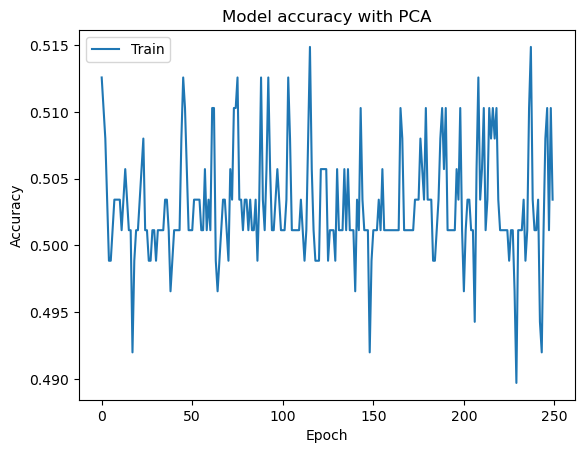

In [202]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_train_reduced.shape[1])
pca.fit(X_train_reduced)

# X_train_pca = pca.transform(X_train_reduced)
# X_test_pca = pca.transform(X_test_reduced)

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=X_train_reduced.shape[1], activation='linear'),
    tf.keras.layers.Dense(3, activation='softmax')  
])

epochs_list = [100,200,250]
batch_size_list = [3,25,50]
for bz in batch_size_list:
    for ep in epochs_list:
        model_pca.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history_pca = model_pca.fit(X_train_reduced, y_train, epochs=ep, batch_size=bz)
        y_preds = np.argmax(model_pca.predict(X_test_reduced), axis=1)
        conf_matrix = confusion_matrix(y_test, y_preds)
        var = pca.explained_variance_ratio_
        test_loss, test_accuracy = model_pca.evaluate(X_test_reduced, y_test, verbose=2)
        save_results_NN("Linear-softmax",conf_matrix,test_accuracy,"SMOTE Over Sampling",ep,bz,var,test_loss,"Delta_LR,delta_WMD,delta_rogue_L")


# uncomment to analyze weights and PCA variance
# print("Shape of components_: ", pca.components_.shape)


# for i, component in enumerate(pca.components_):
#     print(f"Component {i+1}:")
#     for feature, weight in zip(list(x_train.columns), component):
#         print(f"{feature}: {weight}")

# average_weights = np.mean(pca.components_, axis=0)

# for feature, avg_weight in zip(list(X_train_reduced.columns), average_weights):
#     print(f"{feature}: {avg_weight}")

# print(pca.components_)

plt.plot(history_pca.history['accuracy'])
plt.title('Model accuracy with PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# print('Explained variance ratio: ', pca.explained_variance_ratio_)

# test_loss, test_accuracy = model_pca.evaluate(X_test_reduced, y_test, verbose=2)
# print(f'\nTest accuracy: {test_accuracy}')

In [205]:
temp = result_list_pca
for item in temp:
    for key, value in item.items():
        if isinstance(value, np.ndarray):
            item[key] = value.tolist()
temp = sorted(temp, key=lambda x: x['Model Architecture'])
with open('data/results_pca1.json', 'w') as json_file:
    json.dump(temp, json_file, indent=2)

In [2]:
with open('data/results_pca.json', encoding='utf-8') as inputfile:
    df = pd.read_json(inputfile)

df.to_csv('data/csv_res_NN.csv', encoding='utf-8', index=False)

In [213]:
res = json.load(open(r'data/results_pca.json'))
res_df = pd.DataFrame(res)
result_pca = res_df.drop(columns =['Variance Ratios'])

print(result_pca.to_markdown())

|    | Model Architecture   | Sampling Technique   |   Testing Accuracy | Confusion Matrix                           |   epochs |   batch  size |     Loss | Dropped columns (PCA)            |
|---:|:---------------------|:---------------------|-------------------:|:-------------------------------------------|---------:|--------------:|---------:|:---------------------------------|
|  0 | Linear-softmax       | No Sampling          |           0.475    | [[1, 15, 9], [0, 23, 19], [2, 18, 33]]     |      100 |             3 | 1.01022  | Delta_LR                         |
|  1 | Linear-softmax       | No Sampling          |           0.491667 | [[1, 15, 9], [0, 26, 16], [3, 18, 32]]     |      200 |             3 | 1.00994  | Delta_LR                         |
|  2 | Linear-softmax       | No Sampling          |           0.5      | [[1, 15, 9], [0, 26, 16], [3, 17, 33]]     |      250 |             3 | 1.00632  | Delta_LR                         |
|  3 | Linear-softmax       | No Samplin